## Entrenamiento de Modelo

### Relevancia de la Estrategia de MLOps

La implementación de una estrategia de MLOps en el análisis del dataset de hongos cobra una importancia crucial, especialmente cuando abordamos la pregunta: *"¿podemos determinar si un hongo es comestible basándonos en sus características físicas?"*. Esta pregunta no solo plantea un desafío analítico y de modelado significativo, sino que también implica una profunda responsabilidad ética y de seguridad. En ámbitos donde la salud humana podría estar en juego, la precisión y fiabilidad de las predicciones de nuestro modelo no son meramente objetivos deseables, sino imperativos críticos.

En este contexto, una estrategia de MLOps es esencial, ya que permite la iteración continua y sistemática sobre el modelo, buscando optimizar su desempeño mientras se asegura la precisión y fiabilidad del sistema. La incorporación de MLOps facilita una mejora constante mediante la automatización, la integración y la entrega continuas, junto con el monitoreo y mantenimiento en producción, lo que es crucial para manejar la delicada naturaleza de la pregunta de investigación y garantizar la seguridad de las predicciones.

En consonancia con este enfoque iterativo y basado en la necesidad de equilibrar la precisión con la responsabilidad, elegimos comenzar nuestro proceso de modelado con un modelo base sencillo: la regresión logística. Esta elección se fundamenta en su interpretabilidad, simplicidad y eficacia probada como punto de partida en problemas de clasificación. A partir de este modelo base, podemos evaluar su desempeño como línea de base y, apoyados por la infraestructura y prácticas que MLOps facilita, proceder a experimentar y mejorar iterativamente. Esto nos permite explorar modelos más complejos y ajustar parámetros con el objetivo final de optimizar la precisión y la seguridad de nuestras predicciones, garantizando así que nuestro sistema de predicción evolucione de manera responsable y efectiva para proteger la salud y el bienestar de las personas.

### Importación de Librerías

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import scipy.stats as ss
import json
from pathlib import Path

from scipy.stats import randint
from scipy.stats import uniform

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer

import mlflow
import mlflow.sklearn

from rich import print
from rich.console import Console
from rich.table import Table

%matplotlib inline

### Carga del Dataset

In [2]:
parent_directory = os.path.dirname(os.getcwd())
path_primary_data = os.path.join(parent_directory, "data", "secondary_data.csv")
df = pd.read_csv(path_primary_data, sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

### Validación de Datos

In [3]:
# Verificar si hay filas duplicadas
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 146

In [4]:
# Verificar si hay valores faltantes en cada columna
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

In [5]:
def detect_outliers_iqr(dataframe):
    """
    Detecta outliers en todas las columnas numéricas de un DataFrame usando el método del rango intercuartílico (IQR).
    
    Parámetros:
    - dataframe: DataFrame de pandas que contiene las variables numéricas.
    
    Retorna:
    - Un DataFrame que contiene solo las filas que son consideradas outliers en alguna de las columnas numéricas.
    """
    outliers_df = pd.DataFrame(columns=dataframe.columns)
    
    # Selecciona solo las columnas numéricas; en caso de que se haya ingresado un DataFrame con columnas categóricas
    numeric_cols = dataframe.select_dtypes(include=['int64', 'float64'])
    
    for column in numeric_cols:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtra los outliers
        filter_outliers = (dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)
        outliers_in_column = dataframe[filter_outliers]
        
        # Agrega los outliers al DataFrame de outliers
        outliers_df = pd.concat([outliers_df, outliers_in_column], axis=0).drop_duplicates().reset_index(drop=True)
    
    return outliers_df


In [6]:
# %%capture --no-display
# Detectando outliers en el DataFrame de variables numéricas
outliers_df = detect_outliers_iqr(df)

C:\Users\ferna\AppData\Local\Temp\ipykernel_19936\2658367427.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers_df = pd.concat([outliers_df, outliers_in_column], axis=0).drop_duplicates().reset_index(drop=True)


### Limpieza de Datos

- Tratar los valores faltantes (imputación, eliminación de filas/columnas, etc.).
- Identificar y manejar valores atípicos (outliers).
- Manejar datos duplicados y/o inconsistentes.

#### Eliminación de outliers

In [7]:
# Eliminar filas con outliers del conjunto de datos original
df_no_outliers = df.drop(outliers_df.index)
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55729 entries, 5340 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 55729 non-null  object 
 1   cap-diameter          55729 non-null  float64
 2   cap-shape             55729 non-null  object 
 3   cap-surface           43419 non-null  object 
 4   cap-color             55729 non-null  object 
 5   does-bruise-or-bleed  55729 non-null  object 
 6   gill-attachment       47257 non-null  object 
 7   gill-spacing          33843 non-null  object 
 8   gill-color            55729 non-null  object 
 9   stem-height           55729 non-null  float64
 10  stem-width            55729 non-null  float64
 11  stem-root             8074 non-null   object 
 12  stem-surface          20474 non-null  object 
 13  stem-color            55729 non-null  object 
 14  veil-type             353 non-null    object 
 15  veil-color      

#### Eliminación de Variables No Deseadas

In [8]:
# Eliminar columnas con alto índice de registros nulos
df_clean = df_no_outliers.drop(columns=['veil-type', 'spore-print-color', 'veil-color', 'stem-root', 'stem-surface', 'gill-spacing'])
df_clean.head(10)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
5340,e,9.58,f,NaN,g,f,s,g,7.46,21.69,u,f,f,g,w
5341,e,8.19,f,NaN,n,f,s,g,6.77,20.02,u,f,f,g,w
5342,e,9.04,f,NaN,g,f,s,g,7.00,21.65,u,f,f,g,w
5343,e,9.49,x,NaN,n,f,s,g,7.77,19.68,u,f,f,g,w
5344,e,10.01,x,NaN,n,f,s,g,7.62,21.06,u,f,f,g,a
5345,e,7.63,f,NaN,n,f,s,p,6.35,20.53,u,f,f,g,a
5346,e,7.80,f,NaN,n,f,s,p,5.52,18.09,u,f,f,d,a
5347,e,9.11,f,NaN,g,f,s,p,7.71,18.91,u,f,f,g,a
5348,e,6.72,f,NaN,n,f,s,p,6.90,19.54,u,f,f,g,a
5349,e,9.69,f,NaN,n,f,s,g,5.47,21.30,u,f,f,d,a


### División de Datos

#### Conjunto de Entrenamiento y Prueba

In [9]:
# División de datos en variables independientes (X) y dependientes (y)
X = df_clean.drop('class', axis=1)  # Características o variables independientes
y = df_clean['class']  # Variable objetivo o dependiente

# División en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Imprimir información sobre la división de datos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento:
(44583, 14)

Tamaño del conjunto de prueba:
(11146, 14)

#### Conjunto de Entrenamiento: Variables Numéricas y Categóricas

In [10]:
# Identificar características numéricas y categóricas en el conjunto de entrenamiento
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

In [11]:
def get_feature_names_out_with_mapping(preprocessor):
  """
  Extrae los nombres de las features transformadas y crea un diccionario con la 
  correspondencia entre nombres originales y transformados.

  Parámetros:
    preprocessor: Objeto ColumnTransformer ya ajustado.

  Retorno:
    - feature_names: Lista con nombres de features transformadas.
    - feature_mapping: Diccionario con la correspondencia entre nombres originales 
      y transformados.
  """
  feature_names = preprocessor.get_feature_names_out()
  feature_mapping = {}

  for i, name in enumerate(feature_names):
    if name.startswith('numeric__'):
      original_name = name.split('__')[1]
      feature_mapping[i] = original_name
    elif name.startswith('categorical__'):
      original_name = name.split('__')[1].split('_')[0]
      feature_mapping[i] = original_name

  return feature_mapping


In [12]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_transformer, categorical_transformer, numeric_features, categorical_features):
        self.numeric_transformer = numeric_transformer
        self.categorical_transformer = categorical_transformer
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.preprocessor = None
        self.feature_mapping = {}

    def fit(self, X, y=None):
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('numeric', self.numeric_transformer, self.numeric_features),
                ('categorical', self.categorical_transformer, self.categorical_features)
            ])
        self.preprocessor.fit(X)
        self.feature_mapping = self.get_feature_names_out_with_mapping()
        return self

    def transform(self, X):
        return self.preprocessor.transform(X)

    def get_feature_names_out_with_mapping(self):
        feature_names = self.preprocessor.get_feature_names_out()
        feature_mapping = {}
        for i, name in enumerate(feature_names):
            if name.startswith('numeric__'):
                original_name = name.split('__')[1]
                feature_mapping[i] = original_name
            elif name.startswith('categorical__'):
                original_name = name.split('__')[1].split('_')[0]
                feature_mapping[i] = original_name
        return feature_mapping

### Transformación de Datos

In [13]:
# Definir transformadores para variables numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputación utilizando la mediana, debido a la distribución sesgada de los datos
    ('standard_scaler', StandardScaler()),  # Estandarización
    ('min_max_scaler', MinMaxScaler())  # Normalización
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación utilizando la moda
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Codificación utilizando OneHotEncoder, solo tenemos variables categóricas nominales
])

In [14]:
# Crear el preprocesador con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

# %%
# Ajusta el preprocesador solo en el conjunto de entrenamiento
preprocessor.fit(X_train)

# Transforma los conjuntos de entrenamiento, validación y prueba
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [15]:
# Crear una instancia del transformador personalizado
custom_preprocessor = CustomPreprocessor(numeric_transformer, categorical_transformer, numeric_features, categorical_features)

# Ajusta el transformador personalizado solo en el conjunto de entrenamiento
custom_preprocessor.fit(X_train)

# Transforma los conjuntos de entrenamiento, validación y prueba
X_train_transformed = custom_preprocessor.transform(X_train)
X_test_transformed = custom_preprocessor.transform(X_test)

In [16]:
# Obtiene los nombres de las características transformadas y el mapeo de características
feature_names = custom_preprocessor.preprocessor.get_feature_names_out()
feature_mapping = custom_preprocessor.feature_mapping

In [17]:
# Convierte las matrices dispersas a matrices densas y crea DataFrames
X_train_transformed = pd.DataFrame(X_train_transformed.toarray(), columns=feature_names)
X_test_transformed = pd.DataFrame(X_test_transformed.toarray(), columns=feature_names)

In [18]:
# Identify numeric and categorical features in the transformed training set
numeric_features = [col for col in feature_names if col.startswith('numeric__')]
categorical_features = [col for col in feature_names if col.startswith('categorical__')]

In [19]:
# Create an instance of the custom transformer
custom_preprocessor = CustomPreprocessor(numeric_transformer, categorical_transformer, numeric_features, categorical_features)

In [20]:
# Crear el pipeline con el preprocesador y el modelo de regresión logística
baseline_pipeline = Pipeline([
    ('preprocessor', custom_preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [21]:
X_train_transformed.head()

,numeric__cap-diameter,numeric__stem-height,numeric__stem-width,categorical__cap-shape_b,categorical__cap-shape_c,categorical__cap-shape_f,categorical__cap-shape_o,categorical__cap-shape_p,categorical__cap-shape_s,categorical__cap-shape_x,...,categorical__habitat_h,categorical__habitat_l,categorical__habitat_m,categorical__habitat_p,categorical__habitat_u,categorical__habitat_w,categorical__season_a,categorical__season_s,categorical__season_u,categorical__season_w
0,0.119432,0.275045,0.178905,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.095223,0.089767,0.211144,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.018560,0.075045,0.024733,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.136378,0.222980,0.172264,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.137024,0.595332,0.168800,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Entrenamiento y Validación del Modelo

In [22]:
# Entrenar el modelo base de regresión logística utilizando el conjunto de entrenamiento transformado
baseline_model = baseline_pipeline.fit(X_train_transformed, y_train)

### Evaluación del Modelo (Baseline)

In [23]:
# Realizar predicciones utilizando el conjunto de prueba transformado
y_pred = baseline_model.predict(X_test_transformed)

In [24]:
# Evaluar el rendimiento del modelo base en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='p')
recall = recall_score(y_test, y_pred, pos_label='p')
f1 = f1_score(y_test, y_pred, pos_label='p')
auc_roc = roc_auc_score(y_test, baseline_model.predict_proba(X_test_transformed)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir los resultados
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.802888928763682

Precision: 0.8277465918203689

Recall: 0.8212921705919797

F1-score: 0.8245067497403946

AUC-ROC: 0.8796573460612851

Confusion Matrix:
 [[3788 1074]
 [1123 5161]]

Classification Report:
               precision    recall  f1-score   support

           e       0.77      0.78      0.78      4862
           p       0.83      0.82      0.82      6284

    accuracy                           0.80     11146
   macro avg       0.80      0.80      0.80     11146
weighted avg       0.80      0.80      0.80     11146

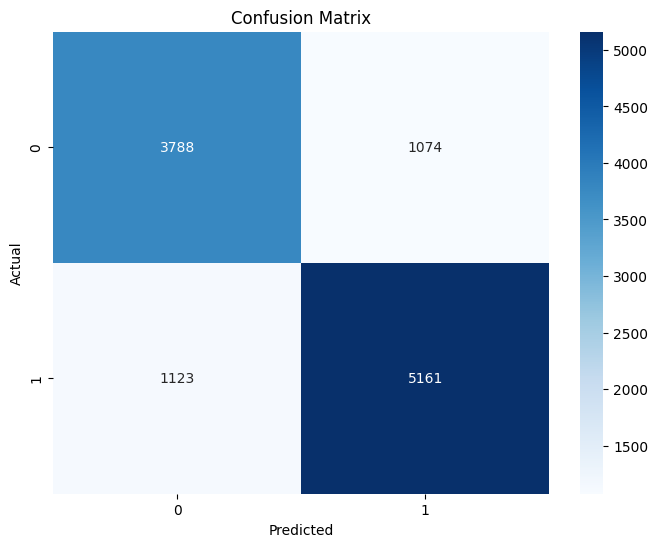

In [25]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_baseline.png')  # Save the confusion matrix plot
plt.show()

### Set Up MLflow

In [26]:
def setup_mlflow_tracking(mlruns_path, experiment_name, tags=None):
    """
    Sets up MLflow tracking with a local file storage backend.
    Creates an experiment if it doesn't exist.

    Args:
        mlruns_path (str): The path to the mlruns directory.
        experiment_name (str): The name of the experiment.

    Returns:
        mlflow.entities.Experiment: The active MLflow experiment.
    """

    tracking_uri = "file:///" + os.path.abspath(mlruns_path)
    os.environ["MLFLOW_TRACKING_URI"] = tracking_uri
    mlflow.set_tracking_uri(tracking_uri)

    print(f"MLflow Tracking URI: {tracking_uri}")

    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment:
        print(f"Existing experiment found: {experiment.name}")
    else:
        experiment = mlflow.create_experiment(
            experiment_name, artifact_location=mlruns_path, tags=tags
        )
        print(f"New experiment created: {experiment.experiment_id}")

    mlflow.set_experiment(experiment.experiment_id)  
    return experiment


In [27]:
mlruns_path = 'c:/Users/ferna/.vscode/GitHub/a01110946/MushroomDataset/mlruns'
experiment_name = "mushroom_classification"
tags = {"data": "mushrooms"}

experiment = setup_mlflow_tracking(mlruns_path, experiment_name)

MLflow Tracking URI: file:///c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\mlruns

Existing experiment found: mushroom_classification

In [28]:
# Confirm data at the end
print(f"Artifact URI: {mlflow.get_artifact_uri()}")
print(f"Experiment Name: {experiment.name}")
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Experiment Location: {experiment.artifact_location}") 

Artifact URI: 
file:///c:\Users\ferna\.vscode\GitHub\a01110946\MushroomDataset\mlruns/683075790092034796/1d2b569cb0944105ab7c3e53e
685f833/artifacts

Experiment Name: mushroom_classification

Experiment ID: 225828532496014960

Experiment Location: c:/Users/ferna/.vscode/GitHub/a01110946/MushroomDataset/mlruns

In [29]:
run = mlflow.active_run()
if run:  # Check if a run is still active
    print(f"run_id: {run.info.run_id}")
    mlflow.end_run()
else:
    print("No active run found")

run_id: 1d2b569cb0944105ab7c3e53e685f833

In [30]:
# Registrar las métricas y artefactos en MLflow
with mlflow.start_run(run_name="Baseline Model Evaluation"):
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc_roc", auc_roc)
    mlflow.log_artifact("confusion_matrix_baseline.png")
    mlflow.log_text(class_report, "classification_report_baseline.txt")